<a href="https://colab.research.google.com/github/kumiori/mec647/blob/main/m4s_1dtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import site
import sys


try : 
    from google.colab import files
except:
    pass
    
try:
    from fenics import *; from mshr import *
except ImportError as e:
    !apt-get install software-properties-common
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y fenics    
    site.addsitedir('/usr/lib/petsc/lib/python3/dist-packages')  # Always appends to end

    from fenics import *; from mshr import *
    from ufl import replace

!fenics-version

2019.2.0.dev0


# A tutorial
- Variational problem setup (static)
- Elastic problem


**Goal:**

Denoting by $u$ the displacement field (vector valued) and by $\alpha$ the scalar damage field we consider the energy functional

$$
		\mathcal{E}_{\ell}(u, \alpha)=
		\dfrac{1}{2}\int_{\Omega} a({\alpha})
		A_0\,\epsilon(u)\cdot\epsilon(u)\,dx
		+
         \,
		\dfrac{G_c}{c_w} \int_{\Omega}\left(
		\dfrac{w(\alpha)}{\ell}+
		{\ell}\,\nabla {\alpha}\cdot\nabla{\alpha}\right)dx
$$

where $\epsilon(u)$ is the strain tensor, $\sigma_0(u)=A_0\,\epsilon(u) = 2{\mu} \epsilon(u) + {\lambda}tr(\epsilon(u))I_2$ the stress of the undamaged material, $a({\alpha})$  the stiffness modulation function though the damage field, $w(\alpha)$ the energy dissipation in an homogeouns process and $\ell$ the internal length.

In the following we will solve, at each time step $t_i$ the minimization problem 

$$
\min\mathcal{E}_{\ell}(u, \alpha),\quad u\in\mathcal{C}_i, \alpha\in \mathcal{D}_i
$$

where $\mathcal{C}_i$ is the space of kinematically admissible displacement at 
time $t_i$ and $\mathcal{D}_i$ the admissible damage fields, that should respect the irreversibility conditions 
$\alpha\geq\alpha_{i-1}$. 




Recall,
$$
\mu = E_0/(2(1+\nu))\quad\text{and}\quad \lambda = E_0 \frac{\nu}{1-\nu^2}
$$
are the two Lamé parameters of the elastic material, $E_0, \nu$ are the corresponding Young modulus and Poisson ratio, and $G_c$ the material toughness.



In [2]:
import matplotlib.pyplot as plt;
import numpy as np;
from IPython.display import clear_output, display, update_display; import time; 
# import dolfin.common.plotting as fenicsplot 
import time
%matplotlib inline
plt.rcParams['image.cmap'] = 'viridis'


## Geometry

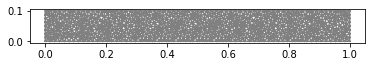

In [3]:
L = 1.; H = .1
cell_size = 0.02
nel = int(L/cell_size)

geom= Rectangle(Point(0., 0.), Point(L, H))
mesh = generate_mesh(geom, nel)
plot(mesh)

In [4]:
left = CompiledSubDomain('near(x[0], 0, 1e-4)')
right = CompiledSubDomain('near(x[0], {}, 1e-4)'.format(L))

boundaries = MeshFunction('size_t', mesh, 1)
boundaries.set_all(0)

left.mark(boundaries, 1) # mark left as 1
right.mark(boundaries,2) # mark right as 2
ds = Measure('ds', subdomain_data=boundaries) # surface measures ds(1), ds(2)




## Constitutive model

In [5]:
# Constitutive functions

E, nu = Constant(1.), Constant(.0)
Gc = Constant(1.)
ell = Constant(0.1)

ndim = mesh.topology().dim()

def w(alpha):
  return alpha

def a(alpha):
  return (1-alpha)**2

def eps(u):
  return sym(grad(u))

def sigma0(u):
  mu = E/(2.*(1.+nu))
  lmbda = E*nu/(1-nu**2.)
  return 2*mu*eps(u) + lmbda*tr(eps(u))*Identity(ndim)

def sigma(alpha, u):
  return a(alpha)*sigma0(u)

## Functional Setting

In [6]:
# Function spaces

V_u = VectorFunctionSpace(mesh, 'P', 1)
V_alpha = FunctionSpace(mesh, 'P', 1)

u = Function(V_u)
du = TrialFunction(V_u)
v = TestFunction(V_u)
alpha = Function(V_alpha)
beta = TestFunction(V_alpha)
dalpha = TrialFunction(V_alpha)


`Function`: generic list of coefficients


`TrialFunction`: list of coefficients for an unknown

`A(u, v) = L(v), for all v`

`h = Function`
`v = TestFunction`

`G = h*v*dx`: linear form in `v`


`u = TrialFunction`

`v = TestFunction`

`A = u*v*dx`: is a bilinear form in `u, v`



In [7]:
# compute the normalisation constant cw
# c_w = \int_0^1 \sqrt{w(z)}dz
# fix Gc so that critical stress is = 1

import sympy

s = sympy.Symbol('s')
cw = float(sympy.integrate(4*sympy.sqrt(w(s)), (s, 0, 1)))
# cw

tmp = 2*(sympy.diff(w(s),s)/sympy.diff(1/a(s),s)).subs({"s":0})

print("Gc = %2.3f"%((ell*cw)/tmp))

Gc = Constant((ell*cw)/tmp)



Gc = 0.267


In [30]:
tmp

1

## Energetics

In [8]:
# cw = 8/3

elastic_energy = 0.5*inner(sigma(alpha, u), eps(u))*dx
dissipated_energy = Gc/cw * (w(alpha)/ell + ell* inner(grad(alpha), grad(alpha)))*dx

total_energy = elastic_energy + dissipated_energy 

E_u = derivative(total_energy, u, v)

from ufl import replace
E_du = replace(E_u, {u: du})

E_alpha = derivative(total_energy, alpha, beta)
E_alpha_alpha = derivative(E_alpha,alpha, dalpha)



## Boundary conditions

In [9]:
# Boundary conditions
u_R = Expression(('t', 0), t=0., degree=0)

bcu_0 = DirichletBC(V_u, u_R, boundaries, 2)
bcu_1 = DirichletBC(V_u, Constant((0., 0.)), boundaries, 1)
bc_u = [bcu_0, bcu_1]


bca_0 = DirichletBC(V_alpha, Constant(0.), boundaries, 2)
bca_1 = DirichletBC(V_alpha, Constant(0.), boundaries, 1)

bc_a = [bca_0, bca_1]


## Elastic (sub)Problem

In [10]:
# Solve displacement problem, using automated derivative, and autmated 
# construction of linear and bilinear forms

# problem_u = LinearVariationalProblem()
problem_u = LinearVariationalProblem(lhs(E_du), rhs(E_du), u, bc_u)
solver_u = LinearVariationalSolver(problem_u)
solver_u.parameters.update({"linear_solver" : "umfpack"})

# Alternatively, compute explicitly:
# 

In [11]:
# u = TrialFunction(V_u)
u_R.t = .1
solver_u.solve()

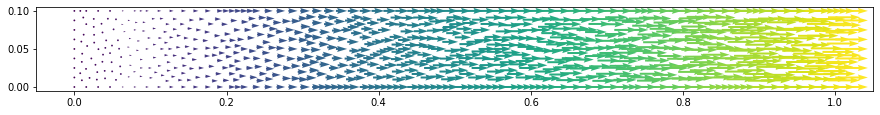

In [12]:
plt.figure(figsize=(15, 8))
plot(u)

## Damage (sub)Problem

In [13]:
import yaml
y = """
  snes:
      snes_type: vinewtonrsls
      snes_linesearch_type: basic
      ksp_type: preonly
      pc_type: lu
      pc_factor_mat_solver_type: mumps
      snes_atol: 1.0e-08
      ksp_rtol: 1.0e-08
      snes_rtol: 1.0e-08
      snes_stol: 0.0
      snes_max_it: 500
      snes_divergence_tolerance: -1.0
""" 
# translate yaml to dictionary
dic = yaml.safe_load(y)

# for option, value in self.parameters["snes"].items():
#     PETScOptions.set(prefix+option, value)
#     # log(LogLevel.INFO, "PETScOptions.set({}, {})".format(prefix + option,value))
#     log(LogLevel.INFO, "Set: {} = {}".format(prefix + option,value))

# snes.setFromOptions()


In [26]:
# Bounds

upperbound = project(Constant(1.), V_alpha)
lowerbound = project(Constant(0.), V_alpha)

# Boundary conditions
# set damage = 0 where we impose displacement boundary conditions

bc_a1 = DirichletBC(V_alpha, Constant(0.), left)
bc_a2 = DirichletBC(V_alpha, Constant(0.), right)

bc_a = [bc_a1, bc_a2]

# Nonlinear problem and solver

problem_alpha = NonlinearVariationalProblem(E_alpha, alpha, bc_a, J=E_alpha_alpha)
problem_alpha.set_bounds(lowerbound, upperbound)

# solver able to solve with bounds: SNES

solver_alpha = NonlinearVariationalSolver(problem_alpha)
# info(solver_alpha.parameters, True)

snes_solver_parameters_bounds = {"nonlinear_solver": "snes", 
                                 "snes_solver": {"maximum_iterations": 300,
                                                 "absolute_tolerance": 1e-10,
                                                 "relative_tolerance": 1e-5,
                                                 "solution_tolerance": 1e-5,
                                                 "report": True,
                                                 "linear_solver" : "mumps"
                                                 }
                                }


# Solver method  |  Description                                                 
# ------------------------------------------------------------------------------
# bicgstab       |  Biconjugate gradient stabilized method                      
# cg             |  Conjugate gradient method                                   
# default        |  default linear solver                                       
# gmres          |  Generalized minimal residual method                         
# minres         |  Minimal residual method                                     
# mumps          |  MUMPS (MUltifrontal Massively Parallel Sparse direct Solver)
# petsc          |  PETSc built in LU solver                                    
# richardson     |  Richardson method                                           
# superlu        |  SuperLU                                                     
# tfqmr          |  Transpose-free quasi-minimal residual method                
# umfpack        |  UMFPACK (Unsymmetric MultiFrontal sparse LU factorization)  

solver_alpha.parameters.update(snes_solver_parameters_bounds)

solver_alpha.solve()




(1, True)

### First order minimisation

In [15]:

def alternate_minimisation(alpha, u,
                           alpha_0 = project(Constant(0.), V_alpha),
                           tol=1e-5, maxiter=100):
  alpha_diff = Function(V_alpha)
  iter = 1; error = 1
  alpha.vector()[:] = alpha_0.vector()
  
  while iter < maxiter and error > tol:
    solver_u.solve()
    # u: solution

    solver_alpha.solve()
    # alpha: solution
    # alpha0: alpha at previous timestep

    alpha_diff.vector()[:] = alpha.vector() - alpha_0.vector()
    error = norm(alpha_diff.vector(), 'l2')
    print("Iteration %d, error %e, alpha_max=%.3f"%(iter, error, max(alpha.vector())))
    alpha_0.assign(alpha)

    iter = iter+1

  return (iter, error)

In [16]:
solver_alpha.solve()

(0, True)

In [17]:
# alpha = Function(V_alpha)
u_R.t = 1.1
alternate_minimisation(alpha, u)

Iteration 1, error 3.880426e+00, alpha_max=0.166
Iteration 2, error 1.714685e+00, alpha_max=0.265
Iteration 3, error 2.123863e+00, alpha_max=0.402
Iteration 4, error 2.510952e+00, alpha_max=0.585
Iteration 5, error 2.400808e+00, alpha_max=0.778
Iteration 6, error 1.985854e+00, alpha_max=0.921
Iteration 7, error 2.195687e+00, alpha_max=0.983
Iteration 8, error 1.703900e+00, alpha_max=1.000
Iteration 9, error 4.935231e-01, alpha_max=1.000
Iteration 10, error 9.449554e-02, alpha_max=1.000
Iteration 11, error 2.547963e-02, alpha_max=1.000
Iteration 12, error 3.060831e-02, alpha_max=1.000
Iteration 13, error 1.963271e-02, alpha_max=1.000
Iteration 14, error 1.343823e-02, alpha_max=1.000
Iteration 15, error 1.042515e-02, alpha_max=1.000
Iteration 16, error 6.054675e-03, alpha_max=1.000
Iteration 17, error 5.043633e-03, alpha_max=1.000
Iteration 18, error 3.318746e-03, alpha_max=1.000
Iteration 19, error 1.791804e-03, alpha_max=1.000
Iteration 20, error 8.714011e-04, alpha_max=1.000
Iteration

(27, 7.196792057543666e-06)

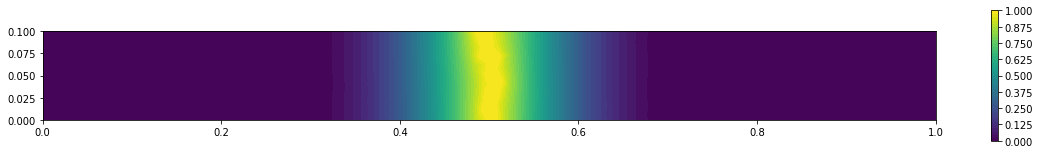

In [18]:
plt.figure(figsize=(20, 8))
plt.colorbar(plot(alpha, vmin= 0, vmax=1.), shrink=.3)

### Evolution

In [19]:
# Evolution monotonically increasing load

loads = np.linspace(.0, 1.5, 30)

energies = []

tot_en = []
sur_en = []
ela_en = []

for (i, t) in enumerate(loads):
  u_R.t = t
  print("** load step: t=%.2f"%t)
  alternate_minimisation(alpha, u, maxiter=200)
  lowerbound.vector()[:] = alpha.vector()
  # postproc
  tot_en.append(assemble(total_energy))
  sur_en.append(assemble(dissipated_energy))
  ela_en.append(assemble(elastic_energy))
  print("** elastic = {:.3f}, surface = {:.3f}, total = {:.3f}".format(ela_en[-1], sur_en[-1], tot_en[-1]))


energies = {'elastic': ela_en, 'surface': sur_en, 'total': tot_en}



** load step: t=0.00
Iteration 1, error 8.829831e+00, alpha_max=0.000
Iteration 2, error 9.150533e-08, alpha_max=0.000
** elastic = 0.000, surface = 0.000, total = 0.000
** load step: t=0.05
Iteration 1, error 0.000000e+00, alpha_max=0.000
** elastic = 0.000, surface = 0.000, total = 0.000
** load step: t=0.10
Iteration 1, error 0.000000e+00, alpha_max=0.000
** elastic = 0.001, surface = 0.000, total = 0.001
** load step: t=0.16
Iteration 1, error 0.000000e+00, alpha_max=0.000
** elastic = 0.001, surface = 0.000, total = 0.001
** load step: t=0.21
Iteration 1, error 0.000000e+00, alpha_max=0.000
** elastic = 0.002, surface = 0.000, total = 0.002
** load step: t=0.26
Iteration 1, error 0.000000e+00, alpha_max=0.000
** elastic = 0.003, surface = 0.000, total = 0.003
** load step: t=0.31
Iteration 1, error 0.000000e+00, alpha_max=0.000
** elastic = 0.005, surface = 0.000, total = 0.005
** load step: t=0.36
Iteration 1, error 0.000000e+00, alpha_max=0.000
** elastic = 0.007, surface = 0.00

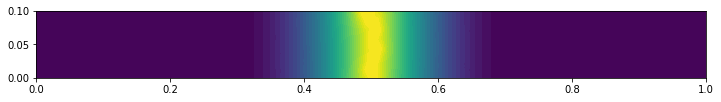

In [20]:
plt.figure(figsize=(12, 8))
plot(alpha)

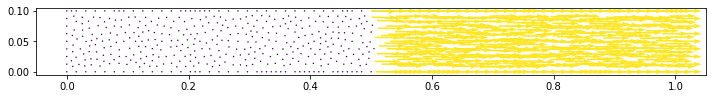

In [21]:
plt.figure(figsize=(12, 8))
plot(u)

([<matplotlib.axis.XTick at 0x7f7417ab87b8>,
 [Text(0, 0, '0'), Text(0, 0, '$t_c$')])

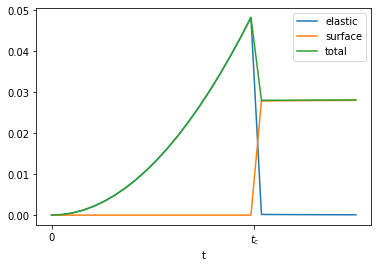

In [37]:
plt.plot(loads, energies['elastic'], label = 'elastic')
plt.plot(loads, energies['surface'], label = 'surface')
plt.plot(loads, energies['total'], label = 'total')
plt.legend()
plt.xlabel('t')
# plt.ylabel('Energies')
tc = sympy.sqrt(2*(sympy.diff(w(s),s)/sympy.diff(1/a(s),s)).subs({"s":0})/E)

plt.xticks([0., tc], labels = ['0', '$t_c$'])

